# External data validation - Sanger dataset

In [5]:
import ast
import pandas as pd
import seaborn as sns

from collections import namedtuple

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, plot_confusion_matrix, roc_auc_score, plot_roc_curve, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import yellowbrick.model_selection as ybms
from yellowbrick.classifier import precision_recall_curve

import sys
sys.path.append('../')

from utils.cv_helpers import *
from utils.experiments import calculate_metrics

In [2]:
with open('../her2-status_config.json', 'r') as f:
    config = ast.literal_eval(f.read())

In [3]:
X = pd.read_csv(config['TRAIN_DATA_FILE']).drop(['Tumour Average Depth', 'Normal Average Depth'], axis=1).set_index('sample_id')
y = pd.read_csv(config['Y_TRAIN_FILE']).set_index('sample_id').Class

In [5]:
X_holdout = pd.read_csv(config['HOLDOUT_DATA_FILE']).set_index('sample_id')
X_holdout = X_holdout.drop(['Tumour Average Depth', 'Normal Average Depth'], axis=1)
y_holdout = pd.read_csv(config['Y_HOLDOUT_FILE']).set_index('sample_id').Class

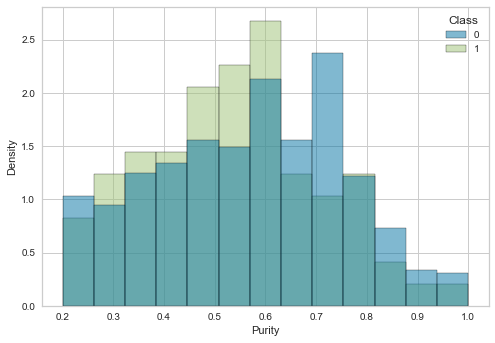

In [33]:
plot_data = X.join(y, how='inner')
sns.histplot(plot_data, x='Purity', hue='Class', stat='density', common_norm=False);

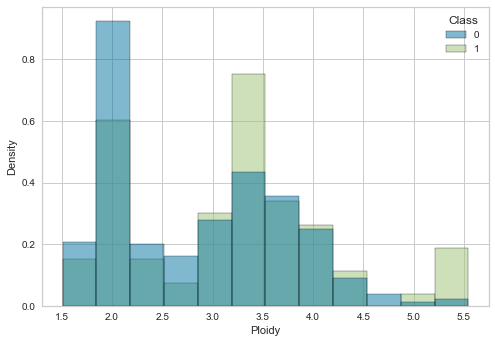

In [34]:
sns.histplot(plot_data, x='Ploidy', hue='Class', stat='density', common_norm=False);

In [6]:
clf = DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=1, min_samples_leaf=1, min_samples_split=2)

model = clf.fit(X.append(X_holdout), y.append(y_holdout))

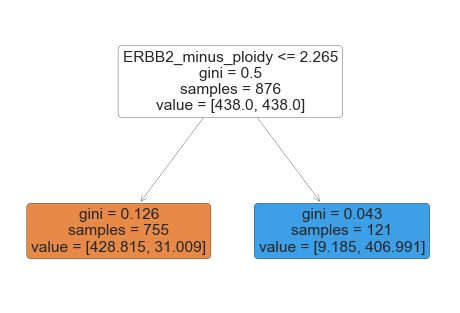

In [7]:
plot_tree(model,
          feature_names=X.columns,
          filled=True,
          rounded=True,
          proportion=False
);

In [8]:
data_sanger = pd.read_excel('../data/sanger dataset.xlsx').set_index('sample_id')

dataset_sanger = data_sanger[[*X.columns, 'IHC HER2']].dropna()

X_sanger = dataset_sanger[X.columns]
y_sanger = dataset_sanger['IHC HER2']

In [9]:
y_sanger_pred = model.predict(X_sanger)
y_sanger_prob = model.predict_proba(X_sanger)

calculate_metrics(y_sanger, y_sanger_pred, y_sanger_prob[:, 1])

,Accuracy,Precision,Recall,F1,AUC_ROC,Kappa,MCC,Balanced accuracy
1,0.952813,0.765432,0.898551,0.826667,0.929566,0.799558,0.803001,0.929566


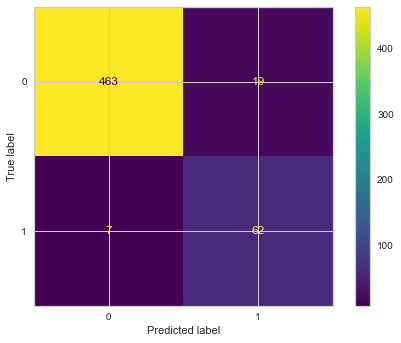

In [11]:
plot_confusion_matrix(model, X_sanger, y_sanger);

## Comparison with ERBB2 and ERBB2/CEP17 single features

In [16]:
clf = DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=1, min_samples_leaf=1, min_samples_split=2)

model_erbb2 = clf.fit(X.append(X_holdout)['ERBB2_copy_number'].to_frame(), y.append(y_holdout))
model_ratio = clf.fit(X.append(X_holdout)['ERBB2_CEP17_ratio'].to_frame(), y.append(y_holdout))

### ERBB2 copy number single feature model score

In [17]:
y_sanger_pred = model_erbb2.predict(X_sanger['ERBB2_copy_number'].to_frame())
y_sanger_prob = model_erbb2.predict_proba(X_sanger['ERBB2_copy_number'].to_frame())

calculate_metrics(y_sanger, y_sanger_pred, y_sanger_prob[:, 1])

,Accuracy,Precision,Recall,F1,AUC_ROC,Kappa,MCC,Balanced accuracy
1,0.724138,0.306977,0.956522,0.464789,0.823697,0.339568,0.439266,0.823697


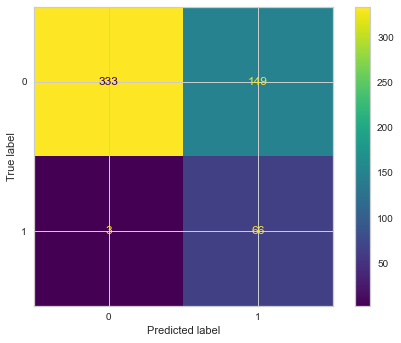

In [18]:
plot_confusion_matrix(model_erbb2, X_sanger['ERBB2_copy_number'].to_frame(), y_sanger);

### ERBB2/CEP17 single feature model score

In [19]:
y_sanger_pred = model_ratio.predict(X_sanger['ERBB2_CEP17_ratio'].to_frame())
y_sanger_prob = model_ratio.predict_proba(X_sanger['ERBB2_CEP17_ratio'].to_frame())

calculate_metrics(y_sanger, y_sanger_pred, y_sanger_prob[:, 1])

,Accuracy,Precision,Recall,F1,AUC_ROC,Kappa,MCC,Balanced accuracy
1,0.945554,0.724138,0.913043,0.807692,0.931625,0.776471,0.78355,0.931625


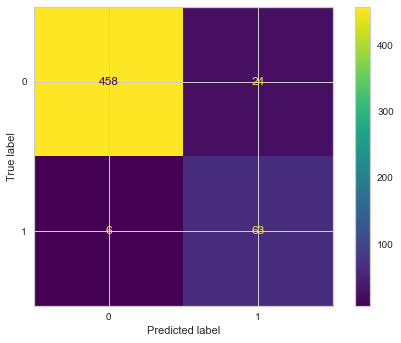

In [21]:
plot_confusion_matrix(model_erbb2, X_sanger['ERBB2_CEP17_ratio'].to_frame(), y_sanger);